# Velocity Function Fitting
***

By Wanga Mulaudzi

<b>Date:</b> 1 August 2021
<br>
<b>Affiliation:</b> Department of Astronomy, University of Cape Town, Private Bag X3, Rondebosch 7701, South Africa
<br>
<b>Contact:</b> MLDWAN001@myuct.ac.za
<br>
<b>Ilifu Jupyter Kernel:</b> PyMultiNest 

This notebook uses the calculated velocity functions to find the fitted parameters for the Schechter function using ```PyMultiNest```.

In [1]:
# Import statements
from astropy.io import ascii
import astropy.units as u
import json
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as mtick
import matplotlib.font_manager
import numpy as np
from numpy import log, exp, pi
import os
import pymultinest
import pylab as pl
import scipy as sp
import scipy.stats
import shutil

In [2]:
# Initiate parameters for plotting
pl.rc('axes',titlesize='large')
#pl.rc('text', usetex=True)
pl.rcParams['text.usetex']=False
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'

In [3]:
# Path for new directory that will be created
# velocity_function_fitting_output is the output folder
dirName = 'velocity_function_fitting_output'

In [ ]:
# # Create a directory to store all the outputs
# if not os.path.exists(dirName):
#     os.makedirs(dirName)
#     print("Directory", dirName, "created.")
# else:    
#     print("Directory", dirName, "already exists and will be overwritten.")
#     shutil.rmtree(dirName)
#     os.makedirs(dirName)

## Defining the functions for MultiNest

In [4]:
# Define the schechter function model
def Smodel(phistar, wstar, alpha, beta):
    '''
    Schechter function parameters
    '''
    return np.log(10)*phistar*pow((w50/wstar), alpha)*np.exp(-pow((w50/wstar), beta))

In [5]:
# Define the schechter function model for the model solutions that take in new x
def Smodelx(w, phistar, wstar, alpha, beta):
    '''
    Schechter function parameters
    '''
    return np.log(10)*phistar*pow((w/wstar), alpha)*np.exp(-pow((w/wstar), beta))

In [6]:
'''MIGHTEE'''
# Define the prior that transforms the unit cube into the parameter cube that is now in log space
# parameters are phistar, wstar, alpha, beta
def prior(cube, ndim, nparams):
    cube[0] = 10**(cube[0] - 3) # log-uniform prior for phistar between 0.0001 and 0.01
    cube[1] = cube[1]*300 + 250 # log-uniform prior for wstar between 250 and 550
    cube[2] = -cube[2]*2.4 - 0.1 # log-uniform prior for alpha between -0.1 and -2.5
    cube[3] = 3*cube[3] + 0.5 # log-uniform prior for beta between 0.5 and 3.5

In [7]:
# Define the loglike function which returns the logarithm of the likelihood (least squares)
def loglike(cube, ndim, nparams):
    # Assign each of the parameters
    phistar, wstar, alpha, beta = cube[0], cube[1], cube[2], cube[3]
    
    # Evaluate the line widths data with the parameters
    vf_model = np.array(Smodel(phistar, wstar, alpha, beta))
    
    phi2 = np.array(phi) #converting phi from a list to an array
    noise2 = np.array(noise)
    
    # Calculate the sum of squares normalised by the residuals
    chi2 = (((vf_model - phi2) / noise2)**2).sum()

    # The log likelihood function
    loglikelihood = -((np.log(2*np.pi*noise2**2)).sum())/2 - chi2/2 # since noise is not constant, the sum over sigma is not just N=len(phi2)

    return loglikelihood

## Reading in the data

In [10]:
# Read in the data from the Zwaan VF method
'''MIGHTEE'''
zwaan_mightee_logw50, zwaan_mightee_phi_Vmax, zwaan_mightee_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_mightee_vf.txt', unpack=True)

'''COSMOS'''
# The index is so that there are no divide by zeros
zwaan_cosmos_logw501, zwaan_cosmos_phi_Vmax1, zwaan_cosmos_phi_Vmax_err1 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_cosmos_vf.txt', unpack=True)
zwaan_cosmos_logw50, zwaan_cosmos_phi_Vmax, zwaan_cosmos_phi_Vmax_err = zwaan_cosmos_logw501[:-2], zwaan_cosmos_phi_Vmax1[:-2], zwaan_cosmos_phi_Vmax_err1[:-2]
#zwaan_cosmos_logw50, zwaan_cosmos_phi_Vmax, zwaan_cosmos_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_cosmos_vf.txt', unpack=True)

'''XMMLSS'''
zwaan_xmmlss_logw50, zwaan_xmmlss_phi_Vmax, zwaan_xmmlss_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_xmmlss_vf.txt', unpack=True)

'''XMMLSS12'''
zwaan_xmmlss12_logw50, zwaan_xmmlss12_phi_Vmax, zwaan_xmmlss12_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_xmmlss12_vf.txt', unpack=True)

'''XMMLSS13'''
zwaan_xmmlss13_logw50, zwaan_xmmlss13_phi_Vmax, zwaan_xmmlss13_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_xmmlss13_vf.txt', unpack=True)

'''XMMLSS14'''
zwaan_xmmlss14_logw50, zwaan_xmmlss14_phi_Vmax, zwaan_xmmlss14_phi_Vmax_err = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/zwaan_xmmlss14_vf.txt', unpack=True)

# Read in the W50 values
'''MIGHTEE'''
mightee_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/mightee_w50.txt', unpack=True)

'''COSMOS'''
cosmos_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/cosmos_w50.txt', unpack=True)

'''XMMLSS'''
xmmlss_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/xmmlss_w50.txt', unpack=True)

'''XMMLSS12'''
xmmlss12_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/xmmlss12_w50.txt', unpack=True)

'''XMMLSS13'''
xmmlss13_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/xmmlss13_w50.txt', unpack=True)

'''XMMLSS14'''
xmmlss14_w50 = np.loadtxt('/users/wanga/mightee/analysis/velocity_function/1bin_plots_velocity_function/xmmlss14_w50.txt', unpack=True)

In [11]:
# Errors
'''MIGHTEE'''
zwaan_mightee_phi_Vmax_upper_err = np.array(zwaan_mightee_phi_Vmax) + np.array(zwaan_mightee_phi_Vmax_err)
zwaan_mightee_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_mightee_phi_Vmax))) - np.abs(np.log10(zwaan_mightee_phi_Vmax_upper_err)))

zwaan_mightee_phi_Vmax_lower_err = np.array(zwaan_mightee_phi_Vmax) - np.array(zwaan_mightee_phi_Vmax_err)
zwaan_mightee_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_mightee_phi_Vmax))) - np.abs(np.log10(zwaan_mightee_phi_Vmax_lower_err)))

'''COSMOS'''
zwaan_cosmos_phi_Vmax_upper_err = np.array(zwaan_cosmos_phi_Vmax) + np.array(zwaan_cosmos_phi_Vmax_err)
zwaan_cosmos_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_cosmos_phi_Vmax))) - np.abs(np.log10(zwaan_cosmos_phi_Vmax_upper_err)))

zwaan_cosmos_phi_Vmax_lower_err = np.array(zwaan_cosmos_phi_Vmax) - np.array(zwaan_cosmos_phi_Vmax_err)
zwaan_cosmos_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_cosmos_phi_Vmax))) - np.abs(np.log10(zwaan_cosmos_phi_Vmax_lower_err)))
# zwaan_cosmos_phi_Vmax_lower_err_size_log = np.where(zwaan_cosmos_phi_Vmax_lower_err_size_log == float('inf'), 20,
#                                             zwaan_cosmos_phi_Vmax_lower_err_size_log)

'''XMMLSS'''
zwaan_xmmlss_phi_Vmax_upper_err = np.array(zwaan_xmmlss_phi_Vmax) + np.array(zwaan_xmmlss_phi_Vmax_err)
zwaan_xmmlss_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss_phi_Vmax_upper_err)))

zwaan_xmmlss_phi_Vmax_lower_err = np.array(zwaan_xmmlss_phi_Vmax) - np.array(zwaan_xmmlss_phi_Vmax_err)
zwaan_xmmlss_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss_phi_Vmax_lower_err)))

'''XMMLSS12'''
zwaan_xmmlss12_phi_Vmax_upper_err = np.array(zwaan_xmmlss12_phi_Vmax) + np.array(zwaan_xmmlss12_phi_Vmax_err)
zwaan_xmmlss12_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss12_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss12_phi_Vmax_upper_err)))

zwaan_xmmlss12_phi_Vmax_lower_err = np.array(zwaan_xmmlss12_phi_Vmax) - np.array(zwaan_xmmlss12_phi_Vmax_err)
zwaan_xmmlss12_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss12_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss12_phi_Vmax_lower_err)))
# zwaan_xmmlss12_phi_Vmax_lower_err_size_log = np.where(zwaan_xmmlss12_phi_Vmax_lower_err_size_log == float('inf'), 20,
#                                             zwaan_xmmlss12_phi_Vmax_lower_err_size_log)

'''XMMLSS13'''
zwaan_xmmlss13_phi_Vmax_upper_err = np.array(zwaan_xmmlss13_phi_Vmax) + np.array(zwaan_xmmlss13_phi_Vmax_err)
zwaan_xmmlss13_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss13_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss13_phi_Vmax_upper_err)))

zwaan_xmmlss13_phi_Vmax_lower_err = np.array(zwaan_xmmlss13_phi_Vmax) - np.array(zwaan_xmmlss13_phi_Vmax_err)
zwaan_xmmlss13_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss13_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss13_phi_Vmax_lower_err)))
# zwaan_xmmlss13_phi_Vmax_lower_err_size_log = np.where(zwaan_xmmlss13_phi_Vmax_lower_err_size_log == float('inf'), 20,
#                                             zwaan_xmmlss13_phi_Vmax_lower_err_size_log)

'''XMMLSS14'''
zwaan_xmmlss14_phi_Vmax_upper_err = np.array(zwaan_xmmlss14_phi_Vmax) + np.array(zwaan_xmmlss14_phi_Vmax_err)
zwaan_xmmlss14_phi_Vmax_upper_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss14_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss14_phi_Vmax_upper_err)))

zwaan_xmmlss14_phi_Vmax_lower_err = np.array(zwaan_xmmlss14_phi_Vmax) - np.array(zwaan_xmmlss14_phi_Vmax_err)
zwaan_xmmlss14_phi_Vmax_lower_err_size_log = np.abs(np.abs(np.log10(np.array(zwaan_xmmlss14_phi_Vmax))) - np.abs(np.log10(zwaan_xmmlss14_phi_Vmax_lower_err)))
# zwaan_xmmlss14_phi_Vmax_lower_err_size_log = np.where(zwaan_xmmlss14_phi_Vmax_lower_err_size_log == float('inf'), 20,
#                                             zwaan_xmmlss14_phi_Vmax_lower_err_size_log)

/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log10


## Plotting the VF

In [12]:
# Bins for the histogram
# Don't do fitting to lower bins
w50_min = np.log10(88)
w50_max = np.log10(528)

no_bins = 8
bin_width = (w50_max - w50_min)/no_bins # Size of W50 bins

w50_bins = np.arange(w50_min, w50_max + bin_width, bin_width)

In [13]:
def schechter_zwaan(W, phistar, Wstar, alpha, beta):
    return np.log(10)*phistar*pow((W/Wstar), alpha)*np.exp(-pow((W/Wstar), beta))*(beta/sp.special.gamma(alpha/beta))

In [14]:
# Parameters used in Zwaan 2010's paper
phi_star = 0.67
W_star = pow(10, 2.21)
alpha_zwaan = 0.10
beta_zwaan = 1.56

zwaan_w = np.linspace(pow(10, w50_min)-200, pow(10, w50_max)+200, 1000)
zwaan_schechter = schechter_zwaan(zwaan_w, phi_star, W_star, alpha_zwaan, beta_zwaan)

/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


In [15]:
def schechter_papastergis(w, phistar, wstar, alpha, beta):
    return np.log(10)*phistar*pow((w/wstar), alpha)*np.exp(-pow((w/wstar), beta))

In [16]:
# Parameters used in Papastergis 2011 paper
pap_phi_star = 0.011
pap_w_star = pow(10, 2.58)
pap_alpha = -0.85
pap_beta = 2.7

pap_w = np.linspace(pow(10, w50_min)-200, pow(10, w50_max)+200, 1000)
pap_schechter = schechter_papastergis(pap_w, pap_phi_star, pap_w_star, pap_alpha, pap_beta)

/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


Papastergis:
$\phi_\star = 0.011$;
W$_\star = 2.58$;
$\alpha = -0.85$;
$\beta = 2.7$

Zwaan:
$\phi_\star = 0.67$;
W$_\star = 2.21$;
$\alpha = 0.10$;
$\beta = 1.56$

In [17]:
# Necessary functions for plotting
def tick_function(x):
    '''
    Returns the tick format of twin x axis
    '''
    return ["%2.f" % i for i in x]

def func(x):
    '''
    Returns the logarithm 
    '''
    funcx = np.log10(x)
    return funcx

In [ ]:
# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2, width, 0.2]

# start with a rectangular Figure
plt.figure(figsize=(13, 10))

# Scatter plot axes set up
ax_scatter = plt.axes(rect_scatter)
ax_scatter.xaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.yaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.axes.tick_params(axis='both', which='minor', length=5, direction='in', labelsize=24, top=True, right=True)
ax_scatter.axes.tick_params(axis='both', which='major', length=10, direction='in', labelsize=24, top=True, right=True)
ax_scatter.axes.tick_params(axis='x', pad=20)
ax_scatter.tick_params(axis='both', labelsize=24, labeltop=False, labelbottom=False)
ax_scatter.xaxis.set_label_position('top')
ax_scatter.set_xlabel(r'$W_{50}$ [km s$^{-1}$]', fontsize=24, labelpad=40)
ax_scatter.set_ylabel(r'log $\phi(\mathrm{W}_{50})$/[h$^3$Mpc$^{-3}$]', fontsize=24)
#ax_scatter.set_title(r'Zwaan et al. (2019) $\frac{1}{V_\mathrm{max}}$ method', fontsize=20)

# Number of galaxies vs log w
ax_histx = plt.axes(rect_histx)
ax_histx.xaxis.set_minor_locator(AutoMinorLocator())
ax_histx.yaxis.set_minor_locator(AutoMinorLocator())
ax_histx.axes.tick_params(axis='x', which='minor', length=5, direction='in', labelsize=24, top=True, bottom=True)
ax_histx.axes.tick_params(axis='x', which='major', length=10, direction='in', labelsize=24, top=True, bottom=True)
ax_histx.axes.tick_params(axis='y', which='minor', length=5, direction='in', labelsize=24, right=True)
ax_histx.axes.tick_params(axis='y', which='major', length=10, direction='in', labelsize=24, right=True)
ax_histx.tick_params(direction='in', labelbottom=True, labeltop=False)
ax_histx.xaxis.set_label_position('bottom')
ax_histx.set_xlabel('log $W_{50}$/[km s$^{-1}$]', fontsize=24, labelpad=15)
ax_histx.set_ylabel(r'$N_\mathrm{gal}$', fontsize=24)
ax_histx.tick_params(axis='both', labelsize=24)

# Velocity Function
'''MIGHTEE'''
ax_scatter.plot(zwaan_mightee_logw50[3:], np.log10(zwaan_mightee_phi_Vmax)[3:], 'o', color='black', markersize=12, label=r'MIGHTEE-HI', alpha=0.8)
ax_scatter.errorbar(zwaan_mightee_logw50[3:], np.log10(zwaan_mightee_phi_Vmax)[3:], yerr=[zwaan_mightee_phi_Vmax_lower_err_size_log[3:], zwaan_mightee_phi_Vmax_upper_err_size_log[3:]], 
                    capsize=5, fmt='', marker=None, ls='none', color='black', alpha=0.8)
    
'''COSMOS'''
ax_scatter.plot(zwaan_cosmos_logw50[3:], np.log10(zwaan_cosmos_phi_Vmax)[3:], 'o', color='royalblue', markersize=12, label=r'COSMOS', alpha=0.8)
ax_scatter.errorbar(zwaan_cosmos_logw50[3:], np.log10(zwaan_cosmos_phi_Vmax)[3:], yerr=[zwaan_cosmos_phi_Vmax_lower_err_size_log[3:], zwaan_cosmos_phi_Vmax_upper_err_size_log[3:]], 
                    capsize=5, fmt='', marker=None, ls='none', color='royalblue', alpha=0.8)
    
'''XMMLSS'''
ax_scatter.plot(zwaan_xmmlss_logw50[3:], np.log10(zwaan_xmmlss_phi_Vmax)[3:], 'o', color='red', markersize=12, label=r'XMM-LSS', alpha=0.8)
ax_scatter.errorbar(zwaan_xmmlss_logw50[3:], np.log10(zwaan_xmmlss_phi_Vmax)[3:], yerr=[zwaan_xmmlss_phi_Vmax_lower_err_size_log[3:], zwaan_xmmlss_phi_Vmax_upper_err_size_log[3:]], 
                    capsize=5, fmt='', marker=None, ls='none', color='red', alpha=0.8)

# '''XMMLSS12'''
# ax_scatter.plot(zwaan_xmmlss12_logw50, np.log10(zwaan_xmmlss12_phi_Vmax), 's', color='salmon', markersize=8, label=r'XMM-LSS 12', alpha=0.6)
# ax_scatter.errorbar(zwaan_xmmlss12_logw50, np.log10(zwaan_xmmlss12_phi_Vmax), yerr=[zwaan_xmmlss12_phi_Vmax_lower_err_size_log, zwaan_xmmlss12_phi_Vmax_upper_err_size_log], 
#             capsize=5, fmt='', marker=None, ls='none', color='salmon', alpha=0.6)
    
# '''XMMLSS13'''
# ax_scatter.plot(zwaan_xmmlss13_logw50, np.log10(zwaan_xmmlss13_phi_Vmax), 's', color='chocolate', markersize=8, label=r'XMM-LSS 13', alpha=0.6)
# ax_scatter.errorbar(zwaan_xmmlss13_logw50, np.log10(zwaan_xmmlss13_phi_Vmax), yerr=[zwaan_xmmlss13_phi_Vmax_lower_err_size_log, zwaan_xmmlss13_phi_Vmax_upper_err_size_log], 
#             capsize=5, fmt='', marker=None, ls='none', color='chocolate', alpha=0.6)
    
# '''XMMLSS14'''
# ax_scatter.plot(zwaan_xmmlss14_logw50, np.log10(zwaan_xmmlss14_phi_Vmax), 's', color='maroon', markersize=8, label=r'XMM-LSS 14', alpha=0.6)
# ax_scatter.errorbar(zwaan_xmmlss14_logw50, np.log10(zwaan_xmmlss14_phi_Vmax), yerr=[zwaan_xmmlss14_phi_Vmax_lower_err_size_log, zwaan_xmmlss14_phi_Vmax_upper_err_size_log], 
#             capsize=5, fmt='', marker=None, ls='none', color='maroon', alpha=0.6)

'''Schechter lines from papers'''
ax_scatter.plot(np.log10(zwaan_w), np.log10(zwaan_schechter), '--', color='darkgreen', label='Zwaan et al. (2010)')
ax_scatter.plot(np.log10(pap_w), np.log10(pap_schechter), '--', color='orange', label='Papastergis et al. (2011)')
#ax_scatter.plot(np.log10(pap_w), np.log10(schechter_papastergis(pap_w, 0.002, 250, -1.5, 2.5)), '-', color='blue', label='Guess')

# # Limits
# #ax_scatter.set_xlim((w50_min-0.14, w50_max+0.14))
# ax_scatter.set_ylim((-4.8, 0.1))
# Limits
ax_scatter.set_xlim((w50_min-0.143, w50_max+0.15))
ax_scatter.set_ylim((-4.8, 1.))

# Histograms
ax_histx.hist([mightee_w50, cosmos_w50, xmmlss_w50], bins=w50_bins, stacked=False, rwidth=0.9, edgecolor='black', color=['black', 'royalblue', 'red'])

# Label each bin
for rect in ax_histx.patches:
    height = rect.get_height()
    ax_histx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=15) 

# Tick positions of the twin x axis
ax_histx.set_ylim((0, 62))
ax_histx.set_xlim(ax_scatter.get_xlim())

# Tick positions of the twin x axis
# Set up the second axis
ax_scatter2 = ax_scatter.twiny()
ax_scatter2.axes.tick_params(axis='both', which = 'major', length=10, direction='in')
ax_scatter2.axes.tick_params(axis='x', which = 'minor', length=5, direction='in')

zticks = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700])
ax_scatter2.set_xticks(func(zticks))
ax_scatter2.set_xticklabels(tick_function(zticks))
ax_scatter_bounds = ax_scatter.get_xbound()
ax_scatter2.set_xlim(ax_scatter_bounds[0], ax_scatter_bounds[1])
ax_scatter2.axes.tick_params(labelsize=20)

# Legend
ax_scatter.legend(loc='lower left', fontsize=20, frameon=False)

plt.show()

## Running PyMultiNest

### MIGHTEE 

In [ ]:
'''MIGHTEE-HI Data'''
# Path for new directory that will be created
zwaan_mightee_dir = dirName+'/zwaan_mightee'

if not os.path.exists(zwaan_mightee_dir):
    os.makedirs(zwaan_mightee_dir)
    print("Directory", zwaan_mightee_dir, "created.")
else:    
    print("Directory", zwaan_mightee_dir, "already exists and will be overwritten.")
    shutil.rmtree(zwaan_mightee_dir)
    os.makedirs(zwaan_mightee_dir)

  analysing data from zwaan_mightee_.txt


/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:98: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-pac

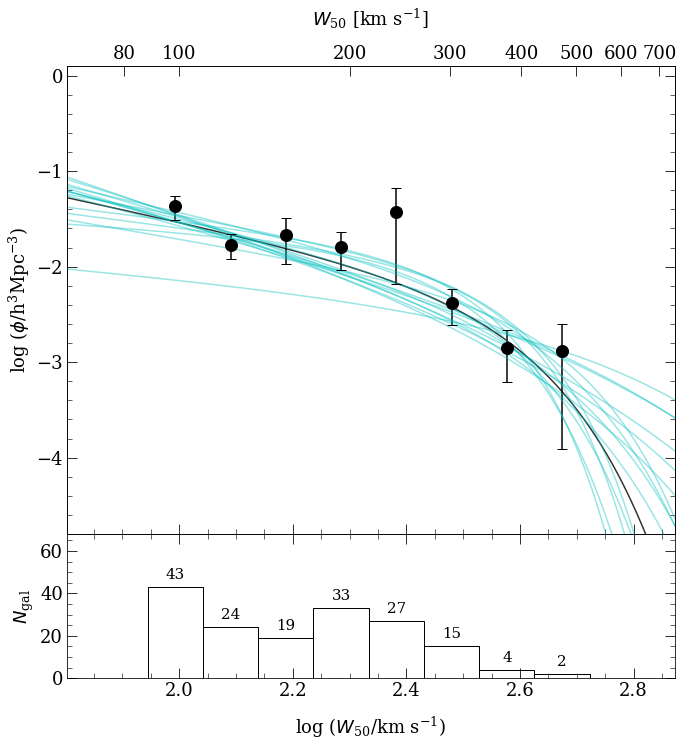

In [21]:
# Read in the data
w50 = pow(10, zwaan_mightee_logw50)[3:]
phi = zwaan_mightee_phi_Vmax[3:]

noise = zwaan_mightee_phi_Vmax_err[3:]

# Number of dimensions our problem has
parameters = ['phistar', 'Wstar', 'alpha', 'beta']
n_params = len(parameters)

# Run PyMultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='zwaan_mightee_', resume=False, verbose=True)
json.dump(parameters, open(zwaan_mightee_dir+'/zwaan_mightee_params.json', 'w')) # Save the parameters

# plot the distribution of a posteriori possible models
# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2, width, 0.2]

# start with a rectangular Figure
plt.figure(figsize=(13, 10))

# Scatter plot axes set up
ax_scatter = plt.axes(rect_scatter)
ax_scatter.xaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.yaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.axes.tick_params(axis='both', which='minor', length=5, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='both', which='major', length=10, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='x', pad=20)
ax_scatter.tick_params(axis='both', labelsize=18, labeltop=False, labelbottom=False)
ax_scatter.xaxis.set_label_position('top')
ax_scatter.set_xlabel(r'$W_{50}$ [km s$^{-1}]$', fontsize=18, labelpad=40)
ax_scatter.set_ylabel(r'log ($\phi$/h$^3$Mpc$^{-3}$)', fontsize=18)
#ax_scatter.set_title(r'Zwaan et al. (2019) $\frac{1}{V_\mathrm{max}}$ method', fontsize=20)

# Number of galaxies vs log w
ax_histx = plt.axes(rect_histx)
ax_histx.xaxis.set_minor_locator(AutoMinorLocator())
ax_histx.yaxis.set_minor_locator(AutoMinorLocator())
ax_histx.axes.tick_params(axis='x', which='minor', length=5, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='x', which='major', length=10, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='y', which='minor', length=5, direction='in', labelsize=18, right=True)
ax_histx.axes.tick_params(axis='y', which='major', length=10, direction='in', labelsize=18, right=True)
ax_histx.tick_params(direction='in', labelbottom=True, labeltop=False)
ax_histx.xaxis.set_label_position('bottom')
ax_histx.set_xlabel(r'log ($W_{50}$/km s$^{-1}$)', fontsize=18, labelpad=15)
ax_histx.set_ylabel(r'$N_\mathrm{gal}$', fontsize=18)
ax_histx.tick_params(axis='both', labelsize=18)

# '''Schechter lines from papers'''
# ax_scatter.plot(np.log10(zwaan_w), np.log10(zwaan_schechter), '--', color='darkgreen', label='Zwaan et al. (2010)')
# ax_scatter.plot(np.log10(pap_w), np.log10(pap_schechter), '--', color='orange', label='Papastergis et al. (2011)')

# Limits
ax_scatter.set_xlim((w50_min-0.143, w50_max+0.15))
ax_scatter.set_ylim((-4.8, 0.1))

# Histograms
ax_histx.hist([mightee_w50], bins=w50_bins, stacked=False, rwidth=1, edgecolor='black', color=['black'], fill=False)

# Label each bin
for rect in ax_histx.patches:
    height = rect.get_height()
    ax_histx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=15) 

# Tick positions of the twin x axis
ax_histx.set_ylim((0, 68))
ax_histx.set_xlim(ax_scatter.get_xlim())

# Tick positions of the twin x axis
# Set up the second axis
ax_scatter2 = ax_scatter.twiny()
ax_scatter2.axes.tick_params(axis='both', which = 'major', length=10, direction='in')
ax_scatter2.axes.tick_params(axis='x', which = 'minor', length=5, direction='in')

zticks = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900])
ax_scatter2.set_xticks(func(zticks))
ax_scatter2.set_xticklabels(tick_function(zticks))
ax_scatter_bounds = ax_scatter.get_xbound()
ax_scatter2.set_xlim(ax_scatter_bounds[0], ax_scatter_bounds[1])
ax_scatter2.axes.tick_params(labelsize=18)

# Plot the distribution of a posteriori possible models
# Modelx is just a linear space of the velocities
modelx = np.linspace(min(pap_w)-500, max(pap_w)+500, 1500)

an = pymultinest.Analyzer(outputfiles_basename='zwaan_mightee_', n_params = n_params)

# get the best fit (highest likelihood) point
bestfit_params_dict = an.get_best_fit()
bestfit_params = bestfit_params_dict.get('parameters')

ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, bestfit_params[0], bestfit_params[1], bestfit_params[2], bestfit_params[3])), '-', color='black', alpha=0.8)#, 
#                    label='Max. Likelihood Fit:'+'\n'+r'$\phi_{\star}$ = %.3f h$^3$ Mpc$^{-3}$ dex$^{-1}$'%(bestfit_params[0])+'\n'
#                 +r'log $W_{\star}$ = %.2f'%(np.log10(bestfit_params[1]))+'\n'+r'$\alpha$ = %.2f'%(bestfit_params[2])+'\n'+r'$\beta$ = %.2f'%(bestfit_params[3]))

# Loop through each possible model and plot it
for (phistar, wstar, alpha, beta) in an.get_equal_weighted_posterior()[::100,:-1]:
    ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, phistar, wstar, alpha, beta)), '-', color='c', alpha=0.4)
    
# Velocity Function
'''MIGHTEE'''
ax_scatter.plot(zwaan_mightee_logw50[3:], np.log10(zwaan_mightee_phi_Vmax[3:]), 'o', color='black', markersize=12, alpha=1)#, label=r'MIGHTEE-HI')
ax_scatter.errorbar(zwaan_mightee_logw50[3:], np.log10(zwaan_mightee_phi_Vmax[3:]), yerr=[zwaan_mightee_phi_Vmax_lower_err_size_log[3:], zwaan_mightee_phi_Vmax_upper_err_size_log[3:]], 
            capsize=5, fmt='', marker=None, ls='none', color='black', alpha=1)
    
# Legend
#ax_scatter.legend(loc='lower left', fontsize=15, frameon=False)

pl.savefig(dirName+'/multinest_mightee_posterior.pdf', bbox_inches='tight', dpi=300)

pl.show()

pl.close()

In [22]:
bestfit_params

[0.0026609434861273686,
 351.2047149597936,
 -1.2652173658613504,
 2.5851904371461982]

In [23]:
# Write the results to a text file
# Create the text files
'''MIGHTEE'''
mightee_params = an.get_best_fit()['parameters']
mightee_errors = an.get_stats()['modes'][0]['sigma']

zwaan_mightee_vf_txt = open(zwaan_mightee_dir+'/multinest_zwaan_mightee_vf.txt', 'w+')

zwaan_mightee_vf_txt.write('Param BestFit 1Sigma\n')

for i in range(len(parameters)):
    zwaan_mightee_vf_txt.write('%s %f %f\n'%(parameters[i], mightee_params[i], mightee_errors[i]))
    
zwaan_mightee_vf_txt.close()

In [24]:
source = '' # Path to where the data dump is

# Read in all the files in the directory
files = os.listdir(source)

# Path to detection folder
dest = dirName+'/zwaan_mightee/'

# Loop through all the files
for file in files:
    if (file.startswith('zwaan_mightee')):
        shutil.move(file, dest)

In [ ]:
# Create the marginal plots for each detection
# Load the parameters
params = json.load(open(dest+'zwaan_mightee_params.json'))
parameters = [r'$\phi_{\star}$', r'$W_{\star}$', r'$\alpha$', r'$\beta$']
n_params = len(params)

# Create the analyzer object
an = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = dest+'zwaan_mightee_')

# Get a dictionary containing information about the logZ and its errors,
# the individual modes and their parameters, quantiles of the parameter posteriors
stats = an.get_stats()

json.dump(stats, open(dest+'zwaan_mightee_stats.json', 'w+'))

# Create the marginal plot
p = pymultinest.PlotMarginal(an)

values = an.get_equal_weighted_posterior()
assert n_params == len(stats['marginals'])
modes = stats['modes']

# Dimensionality of the plot
dim2 = os.environ.get('D', '1' if n_params > 20 else '2') == '2'
nbins = 100 if n_params < 3 else 20

# Set up grid layout
params_count2 = [0, 1, 2] # Grid for j
params_count_indx = 0

if dim2:
    plt.figure(figsize=(25*n_params, 25*n_params))
    #for i in range(n_params):
    for i in range(1, n_params+1, 1):
        # phi* W* alpha beta
        stepsizes = [0.0025, 110, 1, 0.8] 
        axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

        plt.subplot(n_params, n_params, (1 + 5*(i-1)))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        plt.xlabel(parameters[i-1], fontsize=200)

        m = stats['marginals'][i-1]

        plt.xlim(m['5sigma'])
        plt.xticks(rotation=40)

        oldax = plt.gca()
        x,w,patches = oldax.hist(values[:,i-1], bins=nbins, edgecolor='grey', color='grey', histtype='stepfilled', alpha=0.2)
        oldax.set_ylim(0, x.max())
        oldax.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
        oldax.tick_params(axis='x', labelbottom=False, labeltop=True)

        startax, endax = oldax.get_xlim()
        oldax.xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
        oldax.xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 
        oldax.xaxis.set_label_position('top')

        plt.setp(oldax.get_xticklabels(), fontsize=160)
        plt.setp(oldax.get_yticklabels(), fontsize=160)
        plt.setp(oldax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(oldax.yaxis.get_majorticklabels(), fontsize=160)

        newax = plt.gcf().add_axes(oldax.get_position(), sharex=oldax, frameon=False)
        newax.tick_params(axis='x', labelbottom=False, labeltop=True)
        plt.setp(newax.get_xticklabels(), fontsize=160)
        plt.setp(newax.get_yticklabels(), fontsize=160)
        p.plot_marginal(i-1, ls='-', color='blue', linewidth=3)
        newax.set_ylim(0, 1)

        ylim = newax.get_ylim()
        y = ylim[0] + 0.05*(ylim[1] - ylim[0])
        center = m['median']
        low1, high1 = m['1sigma']
        #print(center, low1, high1)
        newax.errorbar(x=center, y=y,
            xerr=np.transpose([[center - low1, high1 - center]]), 
            color='blue', linewidth=2, marker='s')
        oldax.set_yticks([])
        #newax.set_yticks([])
        oldax.tick_params(axis='both', length=30, direction='in', right=True)
        newax.tick_params(axis='both', length=30, direction='in', right=True, pad=30)
        newax.yaxis.set_label_position('right')
        newax.xaxis.set_label_position('top')
        newax.yaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
        newax.tick_params(axis='y', labelleft=False, labelright=True)
        newax.set_ylabel("Probability", fontsize=200, labelpad=30)
        plt.setp(newax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(newax.yaxis.get_majorticklabels(), fontsize=160)
        ylim = oldax.get_ylim()
        newax.set_xlim(m['5sigma'])
        oldax.set_xlim(m['5sigma'])
        #plt.close()

        if i == n_params:
            break

        #for j in range(i):
        for j in range(params_count2[params_count_indx], n_params-1):
            # phi* W* alpha beta
            stepsizes = [0.005, 110, 1, 0.8] 
            axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

            plt.subplot(n_params, n_params, ((n_params + i) + j*n_params))
            p.plot_conditional(i-1, j+1, bins=20, cmap = pl.cm.gray_r)
            for m in modes:
                plt.errorbar(x=bestfit_params[i-1], y=bestfit_params[j+1], xerr=m['sigma'][i-1], yerr=m['sigma'][j+1])

                ########
            if j == 2 and i != 1:
                plt.xlabel(parameters[i-1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j != 2:
                plt.ylabel(parameters[j+1], fontsize=200)
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j == 2:
                plt.xlabel(parameters[i-1], fontsize=200)
                plt.ylabel(parameters[j+1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            else:   
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
            plt.xticks(rotation=40)
            plt.setp(plt.gca().get_xticklabels(), fontsize=160)
            plt.setp(plt.gca().get_yticklabels(), fontsize=160)
            #plt.savefig('cond_%s_%s.pdf' % (params[i], params[j]), bbox_tight=True)
            #plt.close()

        params_count_indx += 1

    plt.savefig(dirName+'/multinest_mightee_marginals.pdf', bbox_inches='tight', dpi=300)
    plt.close()

### COSMOS

In [ ]:
'''COSMOS Data'''
# Path for new directory that will be created
zwaan_cosmos_dir = dirName+'/zwaan_cosmos'

if not os.path.exists(zwaan_cosmos_dir):
    os.makedirs(zwaan_cosmos_dir)
    print("Directory", zwaan_cosmos_dir, "created.")
else:    
    print("Directory", zwaan_cosmos_dir, "already exists and will be overwritten.")
    shutil.rmtree(zwaan_cosmos_dir)
    os.makedirs(zwaan_cosmos_dir)

In [27]:
'''COSMOS'''
# Define the prior that transforms the unit cube into the parameter cube that is now in log space
# parameters are phistar, wstar, alpha, beta
def prior(cube, ndim, nparams):
    cube[0] = 5*10**(-cube[0] - 3) # log-uniform prior for phistar between 0.0002 and 0.02
    cube[1] = cube[1]*300 + 250 # log-uniform prior for wstar between 250 and 550
    cube[2] = -cube[2]*2.1 - 0.4 # log-uniform prior for alpha between -0.4 and -2.5
    cube[3] = 3*cube[3] + 0.5 # log-uniform prior for beta between 1.5 and 2.5

/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:98: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-pac

  analysing data from zwaan_cosmos_.txt


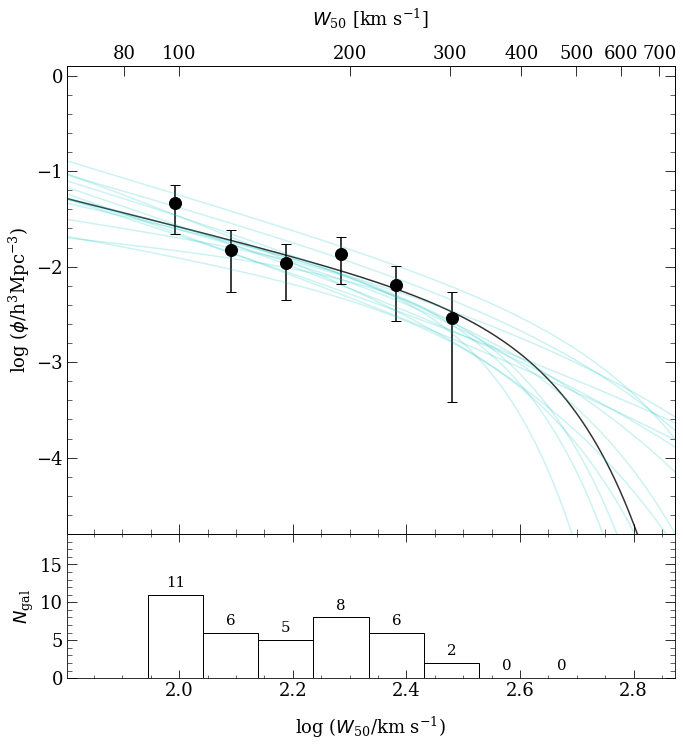

In [29]:
# Read in the data
w50 = pow(10, zwaan_cosmos_logw50)[3:]
phi = zwaan_cosmos_phi_Vmax[3:]

noise = zwaan_cosmos_phi_Vmax_err[3:]

# Number of dimensions our problem has
parameters = ['phistar', 'Wstar', 'alpha', 'beta']
n_params = len(parameters)

# Run PyMultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='zwaan_cosmos_', resume=False, verbose=True)
json.dump(parameters, open(zwaan_cosmos_dir+'/zwaan_cosmos_params.json', 'w')) # Save the parameters

# plot the distribution of a posteriori possible models
# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2, width, 0.2]

# start with a rectangular Figure
plt.figure(figsize=(13, 10))

# Scatter plot axes set up
ax_scatter = plt.axes(rect_scatter)
ax_scatter.xaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.yaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.axes.tick_params(axis='both', which='minor', length=5, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='both', which='major', length=10, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='x', pad=20)
ax_scatter.tick_params(axis='both', labelsize=18, labeltop=False, labelbottom=False)
ax_scatter.xaxis.set_label_position('top')
ax_scatter.set_xlabel(r'$W_{50}$ [km s$^{-1}$]', fontsize=18, labelpad=40)
ax_scatter.set_ylabel(r'log ($\phi$/h$^3$Mpc$^{-3}$)', fontsize=18)
#ax_scatter.set_title(r'Zwaan et al. (2019) $\frac{1}{V_\mathrm{max}}$ method', fontsize=18)

# Number of galaxies vs log w
ax_histx = plt.axes(rect_histx)
ax_histx.xaxis.set_minor_locator(AutoMinorLocator())
ax_histx.yaxis.set_minor_locator(AutoMinorLocator())
ax_histx.axes.tick_params(axis='x', which='minor', length=3, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='x', which='major', length=8, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='y', which='minor', length=5, direction='in', labelsize=18, right=True)
ax_histx.axes.tick_params(axis='y', which='major', length=10, direction='in', labelsize=18, right=True)
ax_histx.tick_params(direction='in', labelbottom=True, labeltop=False)
ax_histx.xaxis.set_label_position('bottom')
ax_histx.set_xlabel(r'log ($W_{50}$/km s$^{-1}$)', fontsize=18, labelpad=15)
ax_histx.set_ylabel(r'$N_\mathrm{gal}$', fontsize=18)
ax_histx.tick_params(axis='both', labelsize=18)

# '''Schechter lines from papers'''
# ax_scatter.plot(np.log10(zwaan_w), np.log10(zwaan_schechter), '--', color='darkgreen', label='Zwaan et al. (2010)')
# ax_scatter.plot(np.log10(pap_w), np.log10(pap_schechter), '--', color='orange', label='Papastergis et al. (2011)')

# Limits
ax_scatter.set_xlim((w50_min-0.143, w50_max+0.15))
ax_scatter.set_ylim((-4.8, 0.1))

# Histograms
ax_histx.hist([cosmos_w50], bins=w50_bins, stacked=False, rwidth=1, edgecolor='black', color=['black'], fill=False)

# Label each bin
for rect in ax_histx.patches:
    height = rect.get_height()
    ax_histx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=15) 

# Tick positions of the twin x axis
ax_histx.set_ylim((0, 19))
ax_histx.set_xlim(ax_scatter.get_xlim())

# Tick positions of the twin x axis
# Set up the second axis
ax_scatter2 = ax_scatter.twiny()
ax_scatter2.axes.tick_params(axis='both', which = 'major', length=10, direction='in')
ax_scatter2.axes.tick_params(axis='x', which = 'minor', length=5, direction='in')

zticks = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900])
ax_scatter2.set_xticks(func(zticks))
ax_scatter2.set_xticklabels(tick_function(zticks))
ax_scatter_bounds = ax_scatter.get_xbound()
ax_scatter2.set_xlim(ax_scatter_bounds[0], ax_scatter_bounds[1])
ax_scatter2.axes.tick_params(labelsize=18)

# Plot the distribution of a posteriori possible models
# Modelx is just a linear space of the velocities
modelx = np.linspace(min(pap_w)-500, max(pap_w)+500, 1500)

an = pymultinest.Analyzer(outputfiles_basename='zwaan_cosmos_', n_params = n_params)

# get the best fit (highest likelihood) point
bestfit_params_dict = an.get_best_fit()
bestfit_params = bestfit_params_dict.get('parameters')

ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, bestfit_params[0], bestfit_params[1], bestfit_params[2], bestfit_params[3])), '-', color='black', alpha=0.8)#, 
#                    label='Max. Likelihood Fit:'+'\n'+r'$\phi_{\star}$ = %.3f h$^3$ Mpc$^{-3}$ dex$^{-1}$'%(bestfit_params[0])+'\n'
#                 +r'log $W_{\star}$ = %.2f'%(np.log10(bestfit_params[1]))+'\n'+r'$\alpha$ = %.2f'%(bestfit_params[2])+'\n'+r'$\beta$ = %.2f'%(bestfit_params[3]))

# Loop through each possible model and plot it
for (phistar, wstar, alpha, beta) in an.get_equal_weighted_posterior()[::100,:-1]:
    ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, phistar, wstar, alpha, beta)), '-', color='c', alpha=0.2)
    

# Velocity Function
'''COSMOS'''
ax_scatter.plot(zwaan_cosmos_logw50[3:], np.log10(zwaan_cosmos_phi_Vmax)[3:], 'o', color='black', markersize=12, alpha=1)
ax_scatter.errorbar(zwaan_cosmos_logw50[3:], np.log10(zwaan_cosmos_phi_Vmax)[3:], yerr=[zwaan_cosmos_phi_Vmax_lower_err_size_log[3:], zwaan_cosmos_phi_Vmax_upper_err_size_log[3:]], 
            capsize=5, fmt='', marker=None, ls='none', color='black', alpha=1)
    
# Legend
ax_scatter.legend(loc='lower left', fontsize=15, frameon=False)

pl.savefig(dirName+'/multinest_cosmos_posterior.pdf', bbox_inches='tight', dpi=300)

pl.show()
pl.close()

In [30]:
bestfit_params

[0.0014875595303742316,
 395.98027101670243,
 -1.4822159765903522,
 3.2017304238846447]

In [31]:
# Write the results to a text file
# Create the text files
'''COSMOS'''
cosmos_params = an.get_best_fit()['parameters']
cosmos_errors = an.get_stats()['modes'][0]['sigma']

zwaan_cosmos_vf_txt = open(zwaan_mightee_dir+'/multinest_zwaan_cosmos_vf.txt', 'w+')

zwaan_cosmos_vf_txt.write('Param BestFit 1Sigma\n')

for i in range(len(parameters)):
    zwaan_cosmos_vf_txt.write('%s %f %f\n'%(parameters[i], cosmos_params[i], cosmos_errors[i]))
    
zwaan_cosmos_vf_txt.close()

In [32]:
source = ''

# Read in all the files in the directory
files = os.listdir(source)

# Path to detection folder
dest = dirName+'/zwaan_cosmos/'

# Loop through all the files
for file in files:
    if (file.startswith('zwaan_cosmos')):
        shutil.move(file, dest)

In [ ]:
# Create the marginal plots for each detection
# Load the parameters
params = json.load(open(dest+'zwaan_cosmos_params.json'))
parameters = [r'$\phi_{\star}$', r'$W_{\star}$', r'$\alpha$', r'$\beta$']
n_params = len(params)

# Create the analyzer object
an = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = dest+'zwaan_cosmos_')

# Get a dictionary containing information about the logZ and its errors,
# the individual modes and their parameters, quantiles of the parameter posteriors
stats = an.get_stats()

json.dump(stats, open(dest+'zwaan_cosmos_stats.json', 'w+'))

# Create the marginal plot
p = pymultinest.PlotMarginal(an)

values = an.get_equal_weighted_posterior()
assert n_params == len(stats['marginals'])
modes = stats['modes']

# Dimensionality of the plot
dim2 = os.environ.get('D', '1' if n_params > 20 else '2') == '2'
nbins = 100 if n_params < 3 else 20

# Set up grid layout
params_count2 = [0, 1, 2] # Grid for j
params_count_indx = 0

if dim2:
    plt.figure(figsize=(25*n_params, 25*n_params))
    #for i in range(n_params):
    for i in range(1, n_params+1, 1):
        # phi* W* alpha beta
        stepsizes = [0.001, 110, 1, 0.7] 
        axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

        plt.subplot(n_params, n_params, (1 + 5*(i-1)))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        plt.xlabel(parameters[i-1], fontsize=200)

        m = stats['marginals'][i-1]

        plt.xlim(m['5sigma'])
        plt.xticks(rotation=40)

        oldax = plt.gca()
        x,w,patches = oldax.hist(values[:,i-1], bins=nbins, edgecolor='grey', color='grey', histtype='stepfilled', alpha=0.2)
        oldax.set_ylim(0, x.max())
        oldax.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
        oldax.tick_params(axis='x', labelbottom=False, labeltop=True)

        startax, endax = oldax.get_xlim()
        oldax.xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
        oldax.xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 
        oldax.xaxis.set_label_position('top')

        plt.setp(oldax.get_xticklabels(), fontsize=160)
        plt.setp(oldax.get_yticklabels(), fontsize=160)
        plt.setp(oldax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(oldax.yaxis.get_majorticklabels(), fontsize=160)

        newax = plt.gcf().add_axes(oldax.get_position(), sharex=oldax, frameon=False)
        newax.tick_params(axis='x', labelbottom=False, labeltop=True)
        plt.setp(newax.get_xticklabels(), fontsize=160)
        plt.setp(newax.get_yticklabels(), fontsize=160)
        p.plot_marginal(i-1, ls='-', color='blue', linewidth=3)
        newax.set_ylim(0, 1)

        ylim = newax.get_ylim()
        y = ylim[0] + 0.05*(ylim[1] - ylim[0])
        center = m['median']
        low1, high1 = m['1sigma']
        #print(center, low1, high1)
        newax.errorbar(x=center, y=y,
            xerr=np.transpose([[center - low1, high1 - center]]), 
            color='blue', linewidth=2, marker='s')
        oldax.set_yticks([])
        #newax.set_yticks([])
        oldax.tick_params(axis='both', length=30, direction='in', right=True)
        newax.tick_params(axis='both', length=30, direction='in', right=True, pad=30)
        newax.yaxis.set_label_position('right')
        newax.xaxis.set_label_position('top')
        newax.yaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
        newax.tick_params(axis='y', labelleft=False, labelright=True)
        newax.set_ylabel("Probability", fontsize=200, labelpad=30)
        plt.setp(newax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(newax.yaxis.get_majorticklabels(), fontsize=160)
        ylim = oldax.get_ylim()
        newax.set_xlim(m['5sigma'])
        oldax.set_xlim(m['5sigma'])
        #plt.close()

        if i == n_params:
            break

        #for j in range(i):
        for j in range(params_count2[params_count_indx], n_params-1):
            # phi* W* alpha beta
            stepsizes = [0.0025, 110, 1, 0.8] 
            axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

            plt.subplot(n_params, n_params, ((n_params + i) + j*n_params))
            p.plot_conditional(i-1, j+1, bins=20, cmap = pl.cm.gray_r)
            for m in modes:
                plt.errorbar(x=bestfit_params[i-1], y=bestfit_params[j+1], xerr=m['sigma'][i-1], yerr=m['sigma'][j+1])

                ########
            if j == 2 and i != 1:
                plt.xlabel(parameters[i-1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j != 2:
                plt.ylabel(parameters[j+1], fontsize=200)
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j == 2:
                plt.xlabel(parameters[i-1], fontsize=200)
                plt.ylabel(parameters[j+1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            else:   
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
            plt.xticks(rotation=40)
            plt.setp(plt.gca().get_xticklabels(), fontsize=160)
            plt.setp(plt.gca().get_yticklabels(), fontsize=160)
            #plt.savefig('cond_%s_%s.pdf' % (params[i], params[j]), bbox_tight=True)
            #plt.close()

        params_count_indx += 1

    plt.savefig(dirName+'multinest_cosmos_marginals.pdf', bbox_inches='tight', dpi=300)
    plt.close()

### XMM-LSS

In [ ]:
'''XMM-LSS Data'''
# Path for new directory that will be created
zwaan_xmmlss_dir = dirName+'/zwaan_xmmlss'

if not os.path.exists(zwaan_xmmlss_dir):
    os.makedirs(zwaan_xmmlss_dir)
    print("Directory", zwaan_xmmlss_dir, "created.")
else:    
    print("Directory", zwaan_xmmlss_dir, "already exists and will be overwritten.")
    shutil.rmtree(zwaan_xmmlss_dir)
    os.makedirs(zwaan_xmmlss_dir)

In [35]:
'''XMMLSS'''
# Define the prior that transforms the unit cube into the parameter cube that is now in log space
# parameters are phistar, wstar, alpha, beta
def prior(cube, ndim, nparams):
    cube[0] = 10**(-3*cube[0]) # log-uniform prior for phistar between 0.0001 and 0.01
    cube[1] = cube[1]*300 + 250 # log-uniform prior for wstar between 250 and 550
    cube[2] = -cube[2]*2.4 - 0.1 # log-uniform prior for alpha between -0.1 and -2.5
    cube[3] = 3*cube[3] + 0.5 # log-uniform prior for beta between 0.5 and 3.5

  analysing data from zwaan_xmmlss_.txt


/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:104: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:110: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:110: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:110: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/anaconda3/lib/python3.6/site-pa

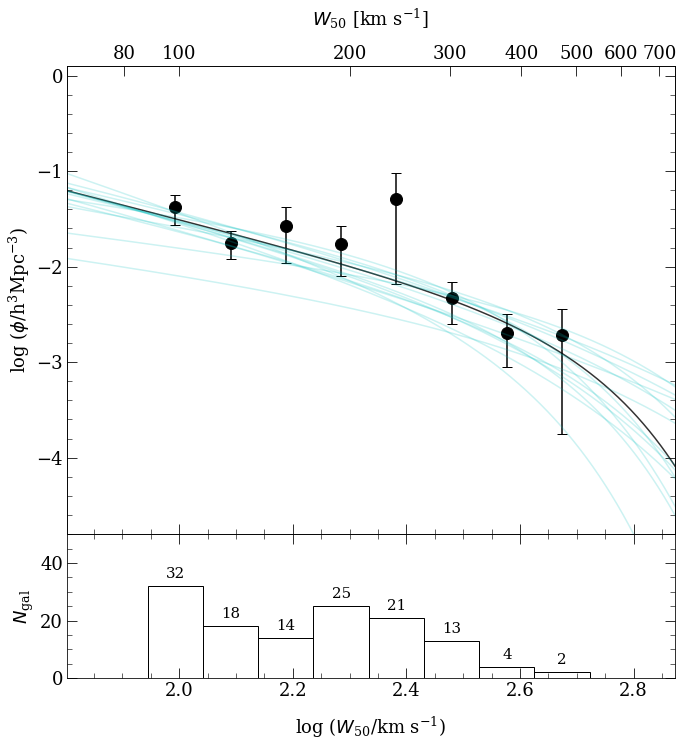

In [36]:
# Read in the data
w50 = pow(10, zwaan_xmmlss_logw50)[3:]
phi = zwaan_xmmlss_phi_Vmax[3:]

noise = zwaan_xmmlss_phi_Vmax_err[3:]

# Number of dimensions our problem has
parameters = ['phistar', 'Wstar', 'alpha', 'beta']
n_params = len(parameters)

# Run PyMultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='zwaan_xmmlss_', resume=False, verbose=True)
json.dump(parameters, open(zwaan_xmmlss_dir+'/zwaan_xmmlss_params.json', 'w')) # Save the parameters

# plot the distribution of a posteriori possible models
# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.2, width, 0.2]

# start with a rectangular Figure
plt.figure(figsize=(13, 10))

# Scatter plot axes set up
ax_scatter = plt.axes(rect_scatter)
ax_scatter.xaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.yaxis.set_minor_locator(AutoMinorLocator())
ax_scatter.axes.tick_params(axis='both', which='minor', length=5, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='both', which='major', length=10, direction='in', labelsize=18, top=True, right=True)
ax_scatter.axes.tick_params(axis='x', pad=20)
ax_scatter.tick_params(axis='both', labelsize=18, labeltop=False, labelbottom=False)
ax_scatter.xaxis.set_label_position('top')
ax_scatter.set_xlabel(r'$W_{50}$ [km s$^{-1}$]', fontsize=18, labelpad=40)
ax_scatter.set_ylabel(r'log ($\phi$/h$^3$Mpc$^{-3}$)', fontsize=18)
#ax_scatter.set_title(r'Zwaan et al. (2019) $\frac{1}{V_\mathrm{max}}$ method', fontsize=20)

# Number of galaxies vs log w
ax_histx = plt.axes(rect_histx)
ax_histx.xaxis.set_minor_locator(AutoMinorLocator())
ax_histx.yaxis.set_minor_locator(AutoMinorLocator())
ax_histx.axes.tick_params(axis='x', which='minor', length=5, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='x', which='major', length=10, direction='in', labelsize=18, top=True, bottom=True)
ax_histx.axes.tick_params(axis='y', which='minor', length=5, direction='in', labelsize=18, right=True)
ax_histx.axes.tick_params(axis='y', which='major', length=10, direction='in', labelsize=18, right=True)
ax_histx.tick_params(direction='in', labelbottom=True, labeltop=False)
ax_histx.xaxis.set_label_position('bottom')
ax_histx.set_xlabel(r'log ($W_{50}$/km s$^{-1}$)', fontsize=18, labelpad=15)
ax_histx.set_ylabel(r'$N_\mathrm{gal}$', fontsize=18)
ax_histx.tick_params(axis='both', labelsize=18)

# Velocity Function
'''XMM-LSS'''
ax_scatter.plot(zwaan_xmmlss_logw50[3:], np.log10(zwaan_xmmlss_phi_Vmax)[3:], 'o', color='black', markersize=12, label=r'XMM-LSS', alpha=1)
ax_scatter.errorbar(zwaan_xmmlss_logw50[3:], np.log10(zwaan_xmmlss_phi_Vmax)[3:], yerr=[zwaan_xmmlss_phi_Vmax_lower_err_size_log[3:], zwaan_xmmlss_phi_Vmax_upper_err_size_log[3:]], 
            capsize=5, fmt='', marker=None, ls='none', color='black', alpha=1)

# '''Schechter lines from papers'''
# ax_scatter.plot(np.log10(zwaan_w), np.log10(zwaan_schechter), '--', color='darkgreen', label='Zwaan et al. (2010)')
# ax_scatter.plot(np.log10(pap_w), np.log10(pap_schechter), '--', color='orange', label='Papastergis et al. (2011)')

# Limits
ax_scatter.set_xlim((w50_min-0.143, w50_max+0.15))
ax_scatter.set_ylim((-4.8, 0.1))

# Histograms
ax_histx.hist([xmmlss_w50], bins=w50_bins, stacked=False, rwidth=1, edgecolor='black', color=['black'], fill=False)

# Label each bin
for rect in ax_histx.patches:
    height = rect.get_height()
    ax_histx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=15) 

# Tick positions of the twin x axis
ax_histx.set_ylim((0, 50))
ax_histx.set_xlim(ax_scatter.get_xlim())

# Tick positions of the twin x axis
# Set up the second axis
ax_scatter2 = ax_scatter.twiny()
ax_scatter2.axes.tick_params(axis='both', which = 'major', length=10, direction='in')
ax_scatter2.axes.tick_params(axis='x', which = 'minor', length=5, direction='in')

zticks = np.array([40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900])
ax_scatter2.set_xticks(func(zticks))
ax_scatter2.set_xticklabels(tick_function(zticks))
ax_scatter_bounds = ax_scatter.get_xbound()
ax_scatter2.set_xlim(ax_scatter_bounds[0], ax_scatter_bounds[1])
ax_scatter2.axes.tick_params(labelsize=18)

# Plot the distribution of a posteriori possible models
# Modelx is just a linear space of the velocities
modelx = np.linspace(min(pap_w)-500, max(pap_w)+500, 1500)

an = pymultinest.Analyzer(outputfiles_basename='zwaan_xmmlss_', n_params = n_params)

# get the best fit (highest likelihood) point
bestfit_params_dict = an.get_best_fit()
bestfit_params = bestfit_params_dict.get('parameters')

ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, bestfit_params[0], bestfit_params[1], bestfit_params[2], bestfit_params[3])), '-', color='black', alpha=0.8)#, 
#                    label='Max. Likelihood Fit:'+'\n'+r'$\phi_{\star}$ = %.3f h$^3$ Mpc$^{-3}$ dex$^{-1}$'%(bestfit_params[0])+'\n'
#                 +r'log $W_{\star}$ = %.2f'%(np.log10(bestfit_params[1]))+'\n'+r'$\alpha$ = %.2f'%(bestfit_params[2])+'\n'+r'$\beta$ = %.2f'%(bestfit_params[3]))

# Loop through each possible model and plot it
for (phistar, wstar, alpha, beta) in an.get_equal_weighted_posterior()[::100,:-1]:
    ax_scatter.plot(np.log10(modelx), np.log10(Smodelx(modelx, phistar, wstar, alpha, beta)), '-', color='c', alpha=0.2)
    
# Legend
#ax_scatter.legend(loc='lower left', fontsize=15, frameon=False)

pl.savefig(dirName+'multinest_xmmlss_posterior.pdf', bbox_inches='tight', dpi=300)
pl.show()

pl.close()

In [37]:
bestfit_params

[0.0011935724719518077,
 496.30131794041284,
 -1.520404030751185,
 2.6091992891199487]

In [38]:
# Write the results to a text file
# Create the text files
'''XMMLSS'''
xmmlss_params = an.get_best_fit()['parameters']
xmmlss_errors = an.get_stats()['modes'][0]['sigma']

zwaan_xmmlss_vf_txt = open(zwaan_mightee_dir+'/multinest_zwaan_xmmlss_vf.txt', 'w+')

zwaan_xmmlss_vf_txt.write('Param BestFit 1Sigma\n')

for i in range(len(parameters)):
    zwaan_xmmlss_vf_txt.write('%s %f %f\n'%(parameters[i], xmmlss_params[i], xmmlss_errors[i]))
    
zwaan_xmmlss_vf_txt.close()

In [39]:
source = ''

# Read in all the files in the directory
files = os.listdir(source)

# Path to detection folder
dest = dirName+'/zwaan_xmmlss/'

# Loop through all the files
for file in files:
    if (file.startswith('zwaan_xmmlss')):
        shutil.move(file, dest)

In [ ]:
# Create the marginal plots for each detection
# Load the parameters
params = json.load(open(dest+'zwaan_xmmlss_params.json'))
parameters = [r'$\phi_{\star}$', r'$W_{\star}$', r'$\alpha$', r'$\beta$']
n_params = len(params)

# Create the analyzer object
an = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = dest+'zwaan_xmmlss_')

# Get a dictionary containing information about the logZ and its errors,
# the individual modes and their parameters, quantiles of the parameter posteriors
stats = an.get_stats()

json.dump(stats, open(dest+'zwaan_xmmlss_stats.json', 'w+'))

# Create the marginal plot
p = pymultinest.PlotMarginal(an)

values = an.get_equal_weighted_posterior()
assert n_params == len(stats['marginals'])
modes = stats['modes']

# Dimensionality of the plot
dim2 = os.environ.get('D', '1' if n_params > 20 else '2') == '2'
nbins = 100 if n_params < 3 else 20

# Set up grid layout
params_count2 = [0, 1, 2] # Grid for j
params_count_indx = 0

if dim2:
    plt.figure(figsize=(25*n_params, 25*n_params))
    #for i in range(n_params):
    for i in range(1, n_params+1, 1):
        # phi* W* alpha beta
        stepsizes = [0.03, 110, 1, 0.7] 
        axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

        plt.subplot(n_params, n_params, (1 + 5*(i-1)))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        plt.xlabel(parameters[i-1], fontsize=200)

        m = stats['marginals'][i-1]

        plt.xlim(m['5sigma'])
        plt.xticks(rotation=40)

        oldax = plt.gca()
        x,w,patches = oldax.hist(values[:,i-1], bins=nbins, edgecolor='grey', color='grey', histtype='stepfilled', alpha=0.2)
        oldax.set_ylim(0, x.max())
        oldax.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
        oldax.tick_params(axis='x', labelbottom=False, labeltop=True)

        startax, endax = oldax.get_xlim()
        oldax.xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
        oldax.xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 
        oldax.xaxis.set_label_position('top')

        plt.setp(oldax.get_xticklabels(), fontsize=160)
        plt.setp(oldax.get_yticklabels(), fontsize=160)
        plt.setp(oldax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(oldax.yaxis.get_majorticklabels(), fontsize=160)

        newax = plt.gcf().add_axes(oldax.get_position(), sharex=oldax, frameon=False)
        newax.tick_params(axis='x', labelbottom=False, labeltop=True)
        plt.setp(newax.get_xticklabels(), fontsize=160)
        plt.setp(newax.get_yticklabels(), fontsize=160)
        p.plot_marginal(i-1, ls='-', color='blue', linewidth=3)
        newax.set_ylim(0, 1)

        ylim = newax.get_ylim()
        y = ylim[0] + 0.05*(ylim[1] - ylim[0])
        center = m['median']
        low1, high1 = m['1sigma']
        #print(center, low1, high1)
        newax.errorbar(x=center, y=y,
            xerr=np.transpose([[center - low1, high1 - center]]), 
            color='blue', linewidth=2, marker='s')
        oldax.set_yticks([])
        #newax.set_yticks([])
        oldax.tick_params(axis='both', length=30, direction='in', right=True)
        newax.tick_params(axis='both', length=30, direction='in', right=True, pad=30)
        newax.yaxis.set_label_position('right')
        newax.xaxis.set_label_position('top')
        newax.yaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
        newax.tick_params(axis='y', labelleft=False, labelright=True)
        newax.set_ylabel("Probability", fontsize=200, labelpad=30)
        plt.setp(newax.xaxis.get_majorticklabels(), rotation=40, fontsize=160)
        plt.setp(newax.yaxis.get_majorticklabels(), fontsize=160)
        ylim = oldax.get_ylim()
        newax.set_xlim(m['5sigma'])
        oldax.set_xlim(m['5sigma'])
        #plt.close()

        if i == n_params:
            break

        #for j in range(i):
        for j in range(params_count2[params_count_indx], n_params-1):
            # phi* W* alpha beta
            stepsizes = [0.017, 110, 1, 0.8] 
            axis_formatters = ['%0.3f', '%d', '%0.2f', '%0.2f']

            plt.subplot(n_params, n_params, ((n_params + i) + j*n_params))
            p.plot_conditional(i-1, j+1, bins=20, cmap = pl.cm.gray_r)
            for m in modes:
                plt.errorbar(x=bestfit_params[i-1], y=bestfit_params[j+1], xerr=m['sigma'][i-1], yerr=m['sigma'][j+1])

                ########
            if j == 2 and i != 1:
                plt.xlabel(parameters[i-1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j != 2:
                plt.ylabel(parameters[j+1], fontsize=200)
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            elif i == 1 and j == 2:
                plt.xlabel(parameters[i-1], fontsize=200)
                plt.ylabel(parameters[j+1], fontsize=200)

                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='x', labelbottom=True)
                plt.gca().axes.tick_params(axis='y', labelleft=True)
                plt.gca().axes.tick_params(axis='both', length=20, direction='in', top=True, right=True, pad=30)
            else:   
                # x axis
                startax, endax = plt.gca().get_xlim()
                plt.gca().xaxis.set_ticks(np.arange(startax, endax, stepsizes[i-1]))
                plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[i-1])) 

                # y axis
                startay, enday = plt.gca().get_ylim()
                plt.gca().yaxis.set_ticks(np.arange(startay, enday, stepsizes[j+1]))
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter(axis_formatters[j+1])) 

                plt.gca().axes.tick_params(axis='both', length=30, direction='in', top=True, right=True, pad=30)
                plt.gca().axes.tick_params(axis='x', labelbottom=False)
                plt.gca().axes.tick_params(axis='y', labelleft=False)
            plt.xticks(rotation=40)
            plt.setp(plt.gca().get_xticklabels(), fontsize=160)
            plt.setp(plt.gca().get_yticklabels(), fontsize=160)
            #plt.savefig('cond_%s_%s.pdf' % (params[i], params[j]), bbox_tight=True)
            #plt.close()

        params_count_indx += 1

    plt.savefig(dirName+'/multinest_xmmlss_marginals.pdf', bbox_inches='tight', dpi=300)
    plt.close()